In [5]:
import sys
import numpy as np
import mmwave.dsp as dsp
import mmwave.clustering as clu
from mmwave.dataloader import DCA1000
from demo.visualizer.visualize import ellipse_visualize
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

plt.rcParams.update({'font.size': 24})
plt.rcParams["figure.figsize"] = (10, 9)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

# plt.close('all')

# QOL settings
loadData = True

targetRangeBin = 5

plotRangeAzimuth = False
plotAzimuth1D = False
plotRangeDopp = False  
plot2DscatterXY = False  
plot2DscatterXZ = False  
plot3Dscatter = False  
plotCustomPlt = True

plotMakeMovie = False
makeMovieTitle = " "
makeMovieDirectory = "./range_angle.mp4"

visTrigger = plot2DscatterXY + plot2DscatterXZ + plot3Dscatter + plotRangeDopp + plotCustomPlt + plotRangeAzimuth + plotAzimuth1D
assert visTrigger < 2, "Can only choose to plot one type of plot at once"

singFrameView = False

#For plotting AxesImage objects (imshow)
def update(frame, data, img):
    
    # Add colorbar only on the first frame
    if frame > 0:
        img.set_data(data[:,:, frame])
    
    return [img]

def movieMaker(fig, ims, title, save_dir):
    # Set up formatting for the Range Azimuth heatmap movies
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=10, metadata=dict(artist='Me'), bitrate=1800)

    plt.title(title)
    print('Done')
    im_ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=3000, blit=False)
    print('Check')
    im_ani.save(save_dir, writer=writer)
    print('Complete')

In [6]:
def phase_unwrapping(phase_cur_frame):
    i=1
    new_signal_phase = phase_cur_frame
    for k,ele in enumerate(new_signal_phase):
        if k==len(new_signal_phase)-1:
            continue
        if new_signal_phase[k+1] - new_signal_phase[k] >= 2*np.pi:
            new_signal_phase[k+1:] = new_signal_phase[k+1:] - 2*np.pi*np.ones(len(new_signal_phase[k+1:]))
    return np.array(new_signal_phase)

In [7]:
import scipy.signal as signal

def fir_filter(signal_data, fs, target_freq, bandwidth=10, num_taps=11, filter_type='bandstop'):
    """
    Design and apply an FIR filter targeting a specific frequency bin.

    Parameters:
    - signal_data: Input signal (1D NumPy array)
    - fs: Sampling frequency (Hz)
    - target_freq: Target frequency to filter (Hz)
    - bandwidth: Bandwidth around target frequency (Hz, default=10)
    - num_taps: Number of filter taps (higher = better frequency resolution, default=101)
    - filter_type: 'lowpass', 'highpass', 'bandpass', or 'bandstop' (default='bandstop')

    Returns:
    - filtered_signal: Output filtered signal
    - fir_coefficients: FIR filter coefficients
    """

    nyquist = fs / 2  # Nyquist frequency
    if filter_type == 'bandpass':
        cutoff = [(target_freq - bandwidth / 2) / nyquist, (target_freq + bandwidth / 2) / nyquist]
    elif filter_type == 'bandstop':
        cutoff = [(target_freq - bandwidth / 2) / nyquist, (target_freq + bandwidth / 2) / nyquist]
    elif filter_type == 'lowpass':
        cutoff = target_freq / nyquist
    elif filter_type == 'highpass':
        cutoff = target_freq / nyquist
    else:
        raise ValueError("Invalid filter type. Choose from 'lowpass', 'highpass', 'bandpass', or 'bandstop'.")

    # Design FIR filter using windowed sinc method
    fir_coefficients = signal.firwin(num_taps, cutoff, window="hamming", pass_zero=True)

    # Apply FIR filter using convolution
    filtered_signal = signal.lfilter(fir_coefficients, 1.0, signal_data)

    return filtered_signal, fir_coefficients


In [8]:

def noise_floor (data_points) :
	"""Calculates the noise floor on the given fourier transform and plots it
	on the original fourier transform generated by the fourier transform module.

	- **parameters**, **types**, **return** and **return types**::
		:param data_points: Array of which noise floor is to be calculated.
		:type arr: floats[]

	"""
	plt.figure (1)
	y_range = np.max(data_points)
	x_range = 182
	interval = len (data_points) / x_range
	#result = np.zeros ((x_range,y_range))
	results = []
	for i in range (x_range):
		data = data_points [int (i * interval) : int ((i + 1) * interval)]
		
		#print (type (data))
		ymin = min (data)[0]
		ymax = max (data)[0]
		y_interval = (ymax - ymin) / y_range
		total_points = len (data)
		print (i)
		for j in range (y_range) :
			#result [i][j] = (data > (j * y_interval)).sum() * 100 / total_points
			tmp = ()
			total = 0
			for elt in data:
				total += elt[0] >= (j * y_interval)
				
			
			y_tmp = j * y_interval
			if total * 100 / total_points < 20:
				for elt in data:
					if elt[0] >= y_tmp:
						results.append (elt)
				break
				#print ("within if ", results)
	
	
	#for row in result:
		#for elt in row:
			#print (elt)
	
	#x = np.array (range(len (result[400])))
	
	x = []
	y = []
	for elt in results:
		x.append (elt[1])
		y.append (elt[0])

	sp2 = plt.subplot(211)
	sp2.plot (x, y, ".", label="Noise Floor")
	legend = sp2.legend(loc='upper right', shadow=True)
	sp2.grid()
	return

Data Loaded!
Best fit line slope = -0.01629187408916015
Average phase_diff = -0.01672250867020264
V_res = 4.96 cm/s
Max noise amplitude = 1.5787260716660378 cm/s
Velocity by best fit method = -5.8734497739065405 cm/s
Velocity by average value = -3.86899709754099 cm/s
DC peak of FFT = 6.02869959776463 cm/s


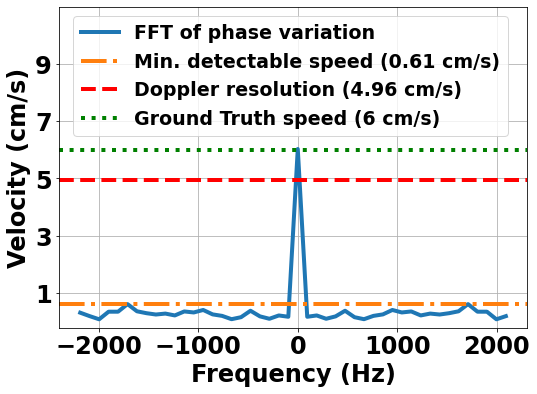

In [25]:
#Filename
fname = "/home/soham/mmPhase/datasets/only_sensor2024-03-29_vicon_15.bin"
# fname = "/home/soham/mmPhase/datasets/only_sensor2024-03-03_Pilot_1A_10.bin"
Tc = 72e-6
Tp = 14e-6
del_t = (Tc + Tp)
l = 3e8/(77e9)
vres = 4.96
scale = (l/(4*np.pi*del_t))*100

numFrames = 151
numADCSamples = 256
numTxAntennas = 3
numRxAntennas = 4
numLoopsPerFrame = 182
numChirpsPerFrame = numTxAntennas * numLoopsPerFrame
numVirtAntennas = numTxAntennas * numRxAntennas

numRangeBins = numADCSamples
numDopplerBins = numLoopsPerFrame
numAngleBins = 64

caponAngleRes = 1 #degrees
caponAngleRange = 90
numCaponAngleBins = (caponAngleRange * 2) // caponAngleRes + 1
rangeBinStartProcess = 11
rangeBinEndProcess = 20
numRangeBinsProcessed = rangeBinEndProcess - rangeBinStartProcess + 1

range_resolution, bandwidth = dsp.range_resolution(numADCSamples, dig_out_sample_rate=4400, freq_slope_const=60.012)
max_range = dsp.max_range(dig_out_sample_rate=4400, freq_slope_const=60.012)

doppler_resolution = dsp.doppler_resolution(bandwidth)

ims = []
max_size = 0

# (1) Reading in adc data
if loadData:
    adc_data = np.fromfile(f'{fname}', dtype=np.uint16)
    adc_data = adc_data.reshape(numFrames, -1)
    adc_data = np.apply_along_axis(DCA1000.organize, 1, adc_data, num_chirps=numChirpsPerFrame, num_rx=numRxAntennas, num_samples=numADCSamples)
    print("Data Loaded!")
    
dataCube = adc_data

range_azimuth = np.zeros((numCaponAngleBins, numRangeBinsProcessed))
range_azimuth_all_frames = np.zeros((numCaponAngleBins, numRangeBinsProcessed, adc_data.shape[0]))
num_vec, steering_vec = dsp.gen_steering_vec(ang_est_range=caponAngleRange, ang_est_resolution=caponAngleRes, num_ant=numVirtAntennas)

for i, frame in enumerate(dataCube):
    # (2) Range Processing
    from mmwave.dsp.utils import Window

    radar_cube = dsp.range_processing(frame, window_type_1d=Window.HANNING)
    
    assert radar_cube.shape == (
    numChirpsPerFrame, numRxAntennas, numADCSamples), "[ERROR] Radar cube is not the correct shape!"
    
    if i==100:
        radar_cube = np.reshape(radar_cube, (3, 182, 4, 256))
        # print(f"radar_cube.shape = {radar_cube.shape}")
        range_fft = radar_cube[0,0,0,:]
        range_fft_abs = np.absolute(range_fft)
        range_fft_abs[:5]=0
        # plt.plot(range_fft_abs)
        
        #Pick the peak of the range fft
        range_peak_bin = np.argmax(range_fft_abs)
        # print(f"range_peak_bin = {range_peak_bin}")
        
        phase_array = radar_cube[0,:,0,range_peak_bin]
        # phase_array = np.arctan2(np.imag(phase_array), np.real(phase_array))
        phase_array = np.angle(phase_array)
        phase_array = phase_unwrapping(phase_array)
        phase_array = phase_array[35:]
        
        #Find out the best fit line 
        y = phase_array
        x = np.arange(len(phase_array))
        m, c = np.polyfit(x, y, 1)
        y_fit = m*x + c
        
        print(f"Best fit line slope = {m}")
        # plt.figure(figsize=(8,6))
        # plt.plot(phase_array)
        # plt.plot(y_fit, c='tab:orange', lw=3)
        
        # Take the 1st difference of the phase_array 
        phase_diff = np.diff(phase_array)
        
        #Subtract best_fit line
        phase_trendless = phase_array - y_fit

        print(f"Average phase_diff = {np.mean(phase_diff)}")
        
        # plt.figure(figsize=(8,6))
        # plt.plot(phase_diff, lw=4)
        # plt.plot(phase_trendless, c='tab:orange', lw=4)
        
        # phase_diff = phase_trendless
        
        #Find the spurious frequency bin
        phase_diff_fft = np.fft.fft(phase_diff, norm=None) / len(phase_diff)
        phase_diff_fft = np.fft.fftshift(phase_diff_fft) 
        spurious_freq_bin = np.argmax(np.abs(phase_diff_fft[int(len(phase_diff_fft)/2):]))
        
        #Filter out the spurious frequency and take FFT again
        phase_diff, _ = fir_filter(phase_diff, fs=1/(72e-6), target_freq=np.fft.fftfreq(n=182, d=72e-6)[spurious_freq_bin], bandwidth=0.4*1/(72e-6), num_taps=101)
        phase_diff_fft_filt = np.fft.fft(phase_diff, norm=None) / len(phase_diff)
        phase_diff_fft_filt = np.fft.fftshift(phase_diff_fft_filt)
        phase_diff_fft_filt = np.abs(phase_diff_fft_filt)
        
        dc_peak = np.abs(phase_diff_fft[int((len(phase_diff_fft))/2)])
        phase_diff_fft_filt[int(len(phase_diff_fft_filt)/2)] = 0
        max_noise_amplitude = np.max(phase_diff_fft_filt)
        signal_to_noise_floor = 10*np.log10(dc_peak/max_noise_amplitude)
        print(f"V_res = {vres} cm/s")
        print(f'Max noise amplitude = {scale * max_noise_amplitude} cm/s')
        print(f"Velocity by best fit method = {scale*m} cm/s")
        print(f"Velocity by average value = {scale*np.mean(phase_diff)} cm/s")
        print(f"DC peak of FFT = {scale*dc_peak} cm/s")
        
        #GT
        gt_speed = 6
        
        #Trim the FFT for plotting 
        phase_diff_fft = phase_diff_fft[50:-50]
        phase_diff_fft_copy = phase_diff_fft.copy()
        phase_diff_fft_copy[int((len(phase_diff_fft))/2)-5:int((len(phase_diff_fft))/2)+5]=0
        max_noise_amplitude = np.max(np.abs(phase_diff_fft_copy))
        frequencies = np.fft.fftshift(np.fft.fftfreq(n=181-35, d=72e-6)) #First 35 points are made 0, hence only 181-35 points are left
        frequencies = frequencies[50:-50]
        plt.figure(figsize=(8,6))
        plt.plot(frequencies, scale*np.abs(phase_diff_fft), lw=4, label='FFT of phase variation')
        # plt.xticks(frequencies[::10], rotation=45)
        plt.axhline(scale*max_noise_amplitude, ls= '-.', lw=4, c='tab:orange', label = f'Min. detectable speed ({scale*max_noise_amplitude:0.2f} cm/s)' )
        plt.axhline(vres, ls= '--', lw=4, c='r', label = f'Doppler resolution ({vres} cm/s)')
        plt.axhline(gt_speed, ls= ':', lw=4, c='g', label = f'Ground Truth speed ({gt_speed} cm/s)')
        # plt.xticks([0, 20, 40, 60, 80])
        # plt.yticks([0, 50, 100, 150, 200])
        plt.yticks([1, 3, 5, 7, 9])
        plt.gca().set_ylim(top=11)
        plt.grid()
        plt.legend(loc='upper left', bbox_to_anchor=(0.01, 1), fontsize=19)
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Velocity (cm/s)")
        plt.tight_layout()
        # plt.savefig(fname='phase_fft_pilot1A_10.png', dpi=300)
        plt.savefig(fname='phase_fft_vicon_15.png', dpi=300)


In [17]:
print(len(phase_diff_fft))


146


## Test done by Argha

Data Loaded!


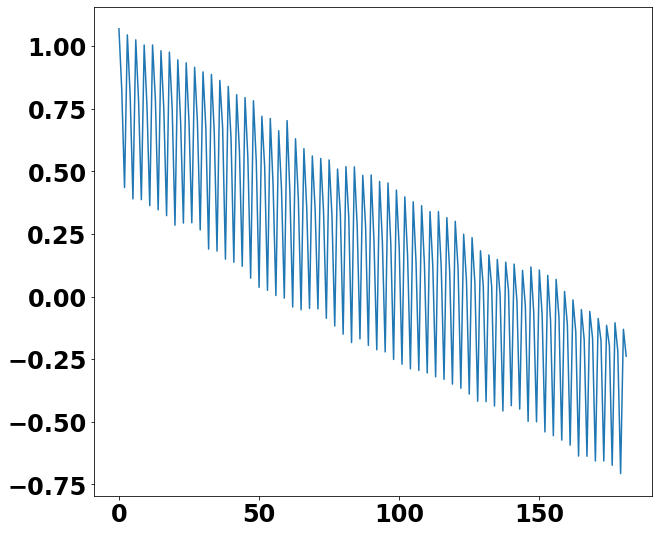

In [10]:
#Filename
fname = "/home/soham/mmPhase/datasets/only_sensor2024-03-03_Pilot_1A_10.bin"

numFrames = 701
numADCSamples = 256
numTxAntennas = 3
numRxAntennas = 4
numLoopsPerFrame = 182
numChirpsPerFrame = numTxAntennas * numLoopsPerFrame
numVirtAntennas = numTxAntennas * numRxAntennas

numRangeBins = numADCSamples
numDopplerBins = numLoopsPerFrame
numAngleBins = 64

caponAngleRes = 1 #degrees
caponAngleRange = 90
numCaponAngleBins = (caponAngleRange * 2) // caponAngleRes + 1
rangeBinStartProcess = 11
rangeBinEndProcess = 20
numRangeBinsProcessed = rangeBinEndProcess - rangeBinStartProcess + 1

range_resolution, bandwidth = dsp.range_resolution(numADCSamples, dig_out_sample_rate=4400, freq_slope_const=60.012)
max_range = dsp.max_range(dig_out_sample_rate=4400, freq_slope_const=60.012)

doppler_resolution = dsp.doppler_resolution(bandwidth)

ims = []
max_size = 0

# (1) Reading in adc data
if loadData:
    adc_data = np.fromfile(f'{fname}', dtype=np.uint16)
    adc_data = adc_data.reshape(numFrames, -1)
    # print(f"DCA1000.organize = {DCA1000.organize}")
    adc_data = np.apply_along_axis(DCA1000.organize, 1, adc_data, num_chirps=numChirpsPerFrame, num_rx=numRxAntennas, num_samples=numADCSamples)
    # print(f'adc_data shape: {adc_data.shape}')
    print("Data Loaded!")
    
dataCube = adc_data

range_azimuth = np.zeros((numCaponAngleBins, numRangeBinsProcessed))
range_azimuth_all_frames = np.zeros((numCaponAngleBins, numRangeBinsProcessed, adc_data.shape[0]))
num_vec, steering_vec = dsp.gen_steering_vec(ang_est_range=caponAngleRange, ang_est_resolution=caponAngleRes, num_ant=numVirtAntennas)

for i, frame in enumerate(dataCube):
    # (2) Range Processing
    from mmwave.dsp.utils import Window

    radar_cube = dsp.range_processing(frame, window_type_1d=Window.HANNING)
    
    assert radar_cube.shape == (
    numChirpsPerFrame, numRxAntennas, numADCSamples), "[ERROR] Radar cube is not the correct shape!"
    
    if i==100:
        radar_cube = np.reshape(radar_cube, (3, 182, 4, 256))
        # print(f"radar_cube.shape = {radar_cube.shape}")
        range_fft = radar_cube[0,0,0,:]
        range_fft_abs = np.absolute(range_fft)
        range_fft_abs[:5]=0
        # plt.plot(range_fft_abs)
        
        #Pick the peak of the range fft
        range_peak_bin = np.argmax(range_fft_abs)
        # print(f"range_peak_bin = {range_peak_bin}")
        
        phase_array = radar_cube[0,:,0,range_peak_bin]
        phase_array = np.arctan2(np.imag(phase_array), np.real(phase_array))
        phase_array = phase_unwrapping(phase_array)
        plt.plot(phase_array)
        # phase_array = phase_array[35:]
        
        # plt.figure(figsize=(8,6))
        # plt.plot(phase_array)
        
        # Take the 1st difference of the phase_array 
        phase_diff = np.diff(phase_array)
        
#         plt.figure(figsize=(8,6))
#         plt.plot(phase_diff)
        
        #Plot the fft of this 
#         phase_diff_fft = np.fft.fft(phase_diff)
#         phase_diff_fft = np.fft.fftshift(phase_diff_fft)
#         plt.plot(phase_diff_fft)
        
#         spurious_freq_bin = np.argmax(phase_diff_fft[int(len(phase_diff_fft)/2):])
#         # print(f'spurious_freq_bin = {spurious_freq_bin}')
#         # print(f'Frequencies = {np.fft.fftfreq(n=182, d=72e-6)}')
#         # phase_diff_fft[spurious_freq_bin-10:spurious_freq_bin+10] = 0
        
#         phase_diff, _ = fir_filter(phase_diff, fs=1/(72e-6), target_freq=np.fft.fftfreq(n=182, d=72e-6)[spurious_freq_bin], bandwidth=0.25*1/(72e-6), num_taps=101)
#         phase_diff_fft_filt = np.fft.fft(phase_diff)
#         phase_diff_fft_filt = np.fft.fftshift(phase_diff_fft_filt)
#         phase_diff_fft_filt = np.abs(phase_diff_fft_filt)
        
#         dc_power = phase_diff_fft[int(len(phase_diff_fft)/2)]
#         phase_diff_fft[int(len(phase_diff_fft)/2)] = 0
#         max_noise_power = np.max(phase_diff_fft)
        
#         signal_to_noise_floor = 10*np.log10(dc_power/max_noise_power)
#         print(f"Noise power = {max_noise_power}" )
        
#         l = 3e8/(77e9)
#         dphi_dt_vres = 4.96
#         scale = l/(4*np.pi)*100
#         print(dphi_dt_vres)
        
#         print(f'Max noise power = {scale * max_noise_power}')
        
#         frequencies = np.fft.fftshift(np.fft.fftfreq(n=181, d=72e-6))
#         # plt.figure(figsize=(8,6))
#         plt.plot(scale*np.abs(phase_diff_fft)[50:-50], lw=4, label='Raw phase variation')
#         # plt.xticks(frequencies, rotation=45)
#         plt.axhline(scale*max_noise_power, ls= '-.', lw=2, c='tab:orange', label = 'Min. achievable speed' )
#         plt.axhline(dphi_dt_vres, ls= '--', lw=4, c='r', label = 'Doppler resolution')
#         plt.xticks([0, 20, 40, 60, 80])
#         # plt.yticks([0, 50, 100, 150, 200])
#         plt.grid()
#         plt.legend(loc='upper left', bbox_to_anchor=(0.01, 0.95), fontsize=20)
#         plt.xlabel("Frequency bin")
#         plt.ylabel("Velocity (cm/s)")
#         plt.tight_layout()
#         plt.savefig(fname='zoom_out_phase.png', dpi=300)
        